In [43]:
import os
import sys
_path = os.path.abspath('../scripts/')
if _path not in sys.path:
    sys.path.append(_path)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
from pyia import GaiaData
from scipy.interpolate import interp1d

import exoplanet as xo
import pymc3 as pm

coord.galactocentric_frame_defaults.set('v4.0');

from model import ComovingHelper

In [81]:
# t = at.Table.read('../cache/probs-150pc_MG12-result.fits')
# d = at.Table.read('../data/150pc_MG12-result.fits.gz')
# joined = at.join(t, d, keys='source_id')

# g = GaiaData(joined)

In [82]:
ht = at.Table.read('../cache/probs-hip_like_gaia.fits')
lg = at.Table.read('../data/hip_like_gaia.fits')
ht = at.join(ht, lg, keys='source_id')
ht.rename_column('source_id', 'HIP')

h = at.Table.read('/mnt/home/apricewhelan/data/Hipparcos/hip2.fits')
joined = at.join(ht, h, keys='HIP')

hg = GaiaData(joined)

(8.0, -4.0)

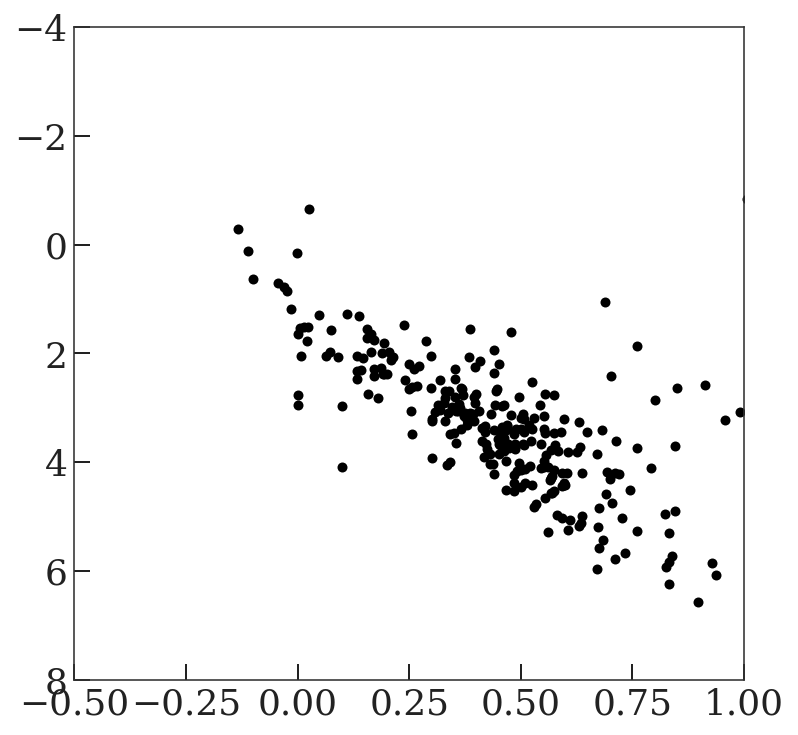

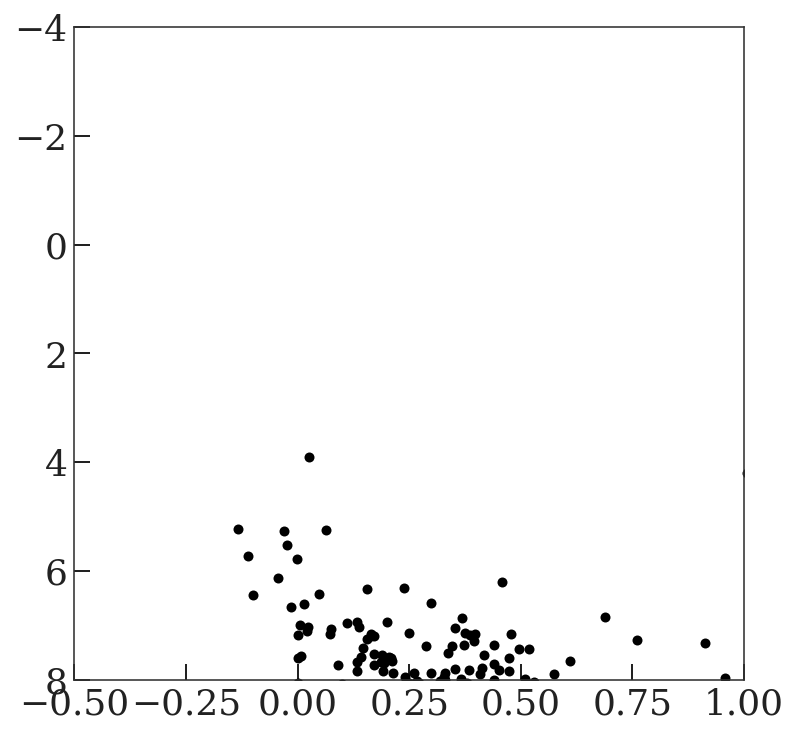

In [159]:
thresh = 0.99
mask = (ht['prob'] > thresh) & (hg.distance < 150*u.pc)

fig, ax = plt.subplots()
ax.plot(hg.data['B-V'][mask], 
        (hg.Hpmag - hg.distmod)[mask],
        marker='o', ls='none')
ax.set_xlim(-0.5, 1)
ax.set_ylim(8, -4)

fig, ax = plt.subplots()
ax.plot(hg.data['B-V'][mask], 
        hg.Hpmag[mask],
        marker='o', ls='none')
ax.set_xlim(-0.5, 1)
ax.set_ylim(8, -4)

In [143]:
derp = hg[(ht['prob'] > 0.99) & np.isfinite(ht['radial_velocity'])]
c = derp.get_skycoord()
v0 = coord.CartesianDifferential([-6.932, 24.301, -9.509] * u.km/u.s)
dv = c.velocity - v0

derp = derp[dv.norm() > 15*u.km/u.s]

(array([39., 46., 32., 14., 10.,  5.,  5.,  2.,  0.,  1.]),
 array([ 0.77847222,  3.14447598,  5.51047975,  7.87648351, 10.24248727,
        12.60849104, 14.9744948 , 17.34049856, 19.70650233, 22.07250609,
        24.43850985]),
 <a list of 10 Patch objects>)

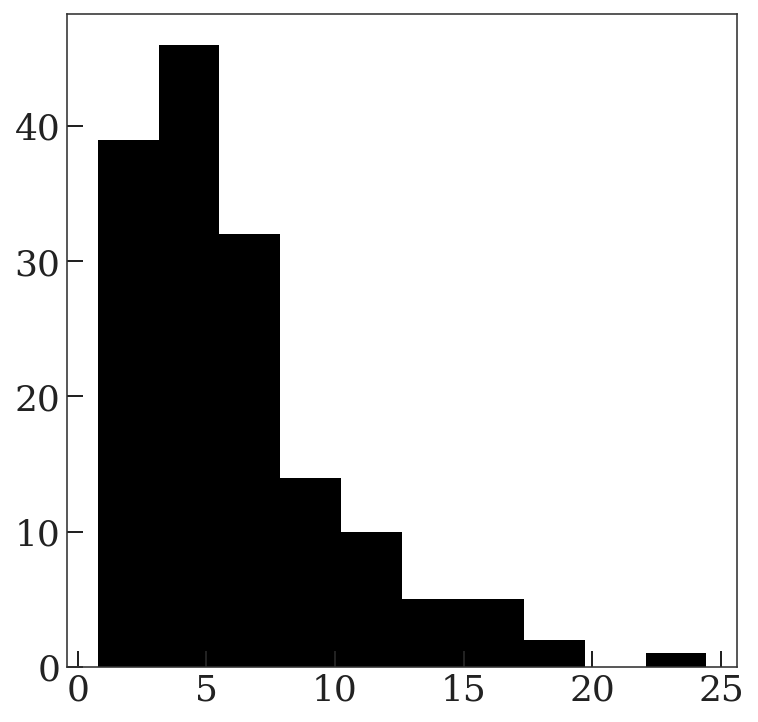

In [144]:
plt.hist(dv.norm().value)

In [145]:
helper = ComovingHelper(derp)

In [146]:
# All in km/s
model_kw = dict()
model_kw['v0'] = v0 = np.array([-6.932, 24.301, -9.509])
model_kw['sigma_v0'] = 0.6 
model_kw['vfield'] = np.array([[-1.49966296, 14.54365055, -9.39127686],
                               [-8.78150468, 22.08294278, -22.9100212],
                               [-112.0987016, 120.8536385, -179.84992332]])
model_kw['sigma_vfield'] = np.array([15.245, 37.146, 109.5])
model_kw['wfield'] = np.array([0.53161301, 0.46602227, 0.00236472])

In [147]:
model = helper.get_model(**model_kw)

In [148]:
n = 0
with model:
    pm.set_data({'y': helper.ys[n],
                 'Cinv': helper.Cinvs[n],
                 'M': helper.Ms[n]})

    test_pt = {'vxyz': helper.test_vxyz[n],
               'r': helper.test_r[n],
               'w': np.array([0.5, 0.5])}
    
    print("starting optimize")
    res = xo.optimize(start=test_pt, progress_bar=False,
                      verbose=False)

    print("done optimize - starting sample")
    trace = pm.sample(
        start=res,
        tune=2000,
        draws=1000,
        cores=1,
        chains=1,
        step=xo.get_dense_nuts_step(target_accept=0.95),
        progressbar=True
    )

starting optimize
done optimize - starting sample


Sequential sampling (1 chains in 1 job)
NUTS: [vxyz, w, r]


Sampling 1 chain for 2_000 tune and 1_000 draw iterations (2_000 + 1_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [149]:
ll_fg = trace.get_values(model.group_logp)
ll_bg = trace.get_values(model.field_logp)
post_prob = np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
post_prob.sum() / len(post_prob)

0.9997887653587059

In [150]:
helper.ys[n]

array([  6.32000017,  28.17      , -11.53      ,  16.        ])

In [151]:
np.sqrt(helper.Cs[n])

array([[ 1.08000003,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.38999998,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.68000001,  0.        ],
       [ 0.        ,  0.        ,  0.        , 23.        ]])

In [152]:
derp.radial_velocity_error[n]

<Quantity 23. km / s>

In [153]:
derp.parallax_error[n]

<Quantity 1.08 mas>

In [169]:
with model:
    val = xo.eval_in_model(model.vars[-1], point=trace[4])
    print(val)

[-6.77905575 24.15934154 -9.47746557]


## Compare to old sample:

In [45]:
oldies = GaiaData(at.Table.read('../data/TheOGGroup.csv', format='ascii.ecsv'))
oldies_prob = g[np.isin(g.source_id, oldies.source_id)]

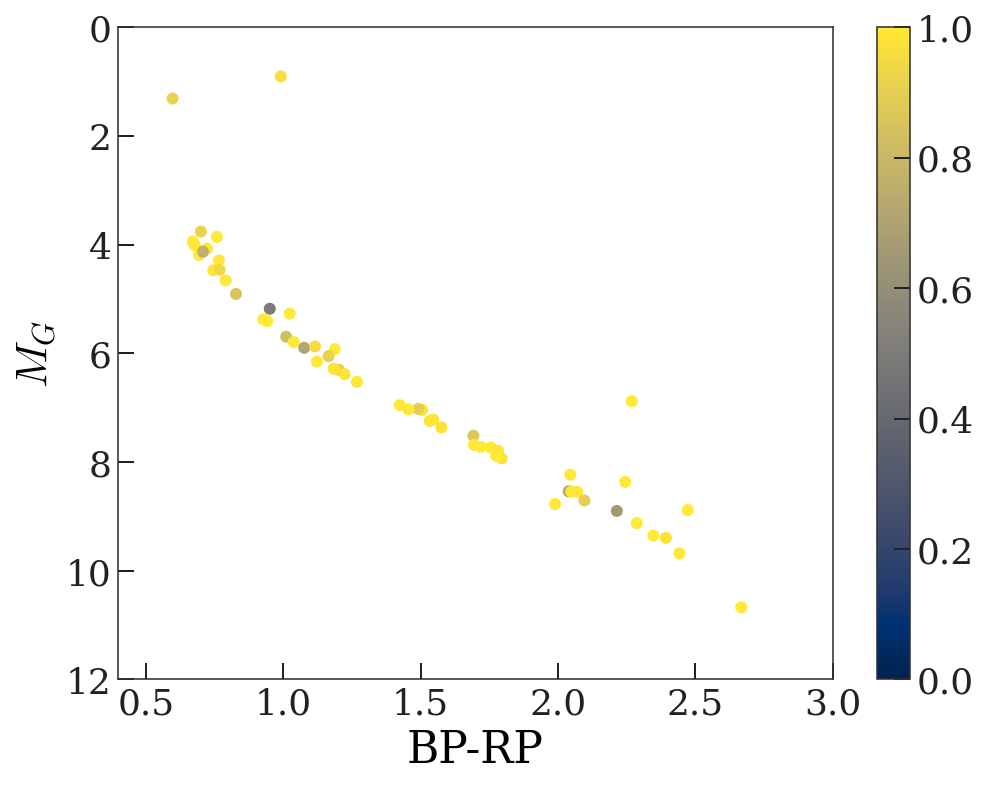

In [46]:
mg = oldies_prob.phot_g_mean_mag - oldies_prob.distmod
bprp = oldies_prob.phot_bp_mean_mag - oldies_prob.phot_rp_mean_mag

# ---

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

cs = ax.scatter(bprp, mg, c=oldies_prob.prob, 
                marker='o', vmin=0, vmax=1, 
                cmap='cividis')

cb = fig.colorbar(cs)

ax.set_xlim(0.4, 3.)
ax.set_ylim(12., 0)

ax.set_xlabel('BP-RP')
ax.set_ylabel('$M_G$')

fig.set_facecolor('w')